### Importing libraries

In [74]:
import darts
import torch
import pandas as pd 
import numpy as np
import warnings
import matplotlib.pyplot as plt 
from pandas.plotting import autocorrelation_plot
from darts.timeseries import TimeSeries
from darts.utils.timeseries_generation import gaussian_timeseries
from darts.utils.timeseries_generation import random_walk_timeseries
from darts.dataprocessing.transformers.scaler import Scaler
from darts.utils.statistics import plot_hist

# jupyter notebook settings
plt.style.use('seaborn')
warnings.filterwarnings("ignore")
np.random.seed(42)    # reproducibility
torch.manual_seed(42) # reproducibility
random_state = 42
%matplotlib inline

### Generate Dataset and implement statistical analysis

367


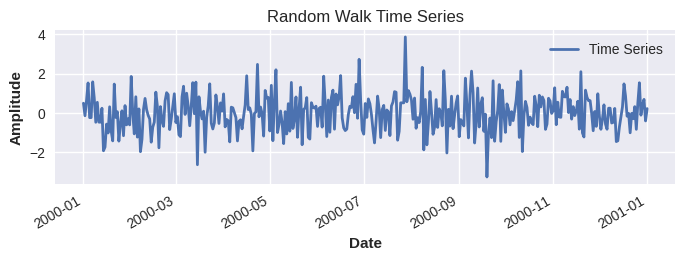

In [75]:
dataset = gaussian_timeseries(start = pd.Timestamp(year=2000, month=1, day=1),
                                 end   = pd.Timestamp(year=2001, month=1, day=1))
plt.figure(figsize=(8, 2))
dataset.plot(label='Time Series')
plt.title('Random Walk Time Series')
plt.ylabel('Amplitude')
plt.xlabel('Date')
plt.legend()
print(len(dataset))

<Axes: xlabel='Lag', ylabel='Autocorrelation'>

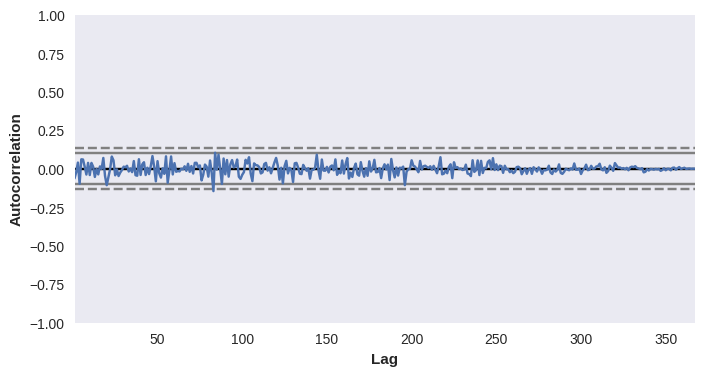

In [76]:
plt.figure(figsize=(8, 4))
autocorrelation_plot(dataset.pd_dataframe())

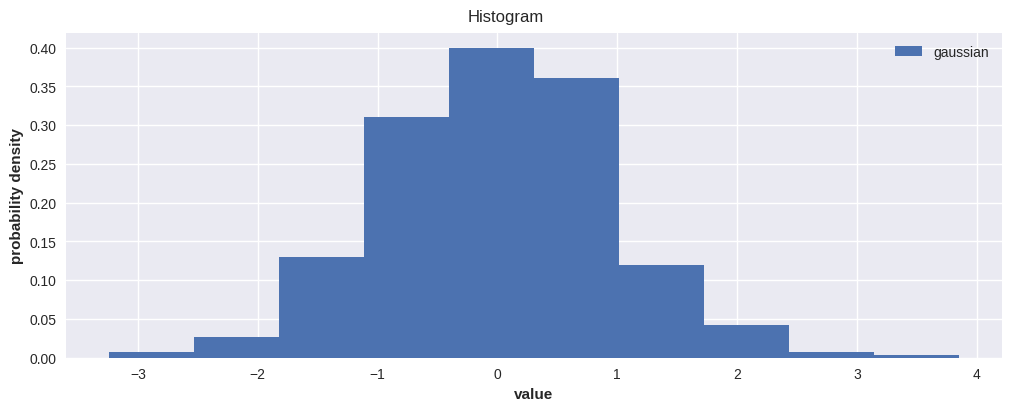

In [77]:
plot_hist(dataset, density=True, fig_size=(10,4))

In [78]:
# scaled time series
scaler = Scaler()
scaled_series = scaler.fit_transform(dataset.copy())

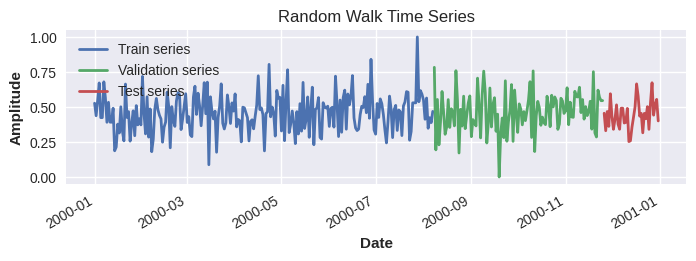

In [79]:
train_size = int(0.6 * len(scaled_series))
valid_size = int(0.3 * len(scaled_series))
test_size  = int(0.1 * len(scaled_series))

train = scaled_series[ : train_size]
val   = scaled_series[train_size : train_size + valid_size]
test  = scaled_series[train_size + valid_size : train_size + valid_size + test_size]

plt.figure(figsize=(8, 2))
train.plot(label='Train series')
val.plot(label='Validation series')
test.plot(label='Test series')
plt.title('Random Walk Time Series')
plt.ylabel('Amplitude')
plt.xlabel('Date')
plt.legend()

#### Models implementation

In [80]:
# General parameters
input_size  = 2 * len(test)
output_size = len(test)
n_epochs    = 50 # number of epochs to ML-based models
batch_size  = 32

if torch.cuda.is_available():
    pl_trainer_kwargs = {'accelerator'      : 'gpu',
                         'devices'          : -1,
                         'auto_select_gpus' : True}
else:
    pl_trainer_kwargs = {'accelerator' : 'cpu'}

In [81]:
from darts.models.forecasting.arima import ARIMA

arima_forecaster = ARIMA(p = 12, 
                         d = 2, 
                         q = 1,
                         random_state = random_state)

arima_forecaster.fit(series = train)

# predict 36 days
arima_predict = arima_forecaster.predict(n = len(test))

In [82]:
from darts.models.forecasting.lgbm import LightGBMModel

lgbm_forecaster = LightGBMModel(lags = input_size,
                                output_chunk_length = output_size,
                                random_state = random_state)

lgbm_forecaster.fit(series = train)
                    #val_series = val)

# predict 36 days
lgbm_predict = lgbm_forecaster.predict(n = len(test),)
                                       #val_series = val)

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000581 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2808
[LightGBM] [Info] Number of data points in the train set: 113, number of used features: 72
[LightGBM] [Info] Start training from score 0.460023
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain

In [84]:
from darts.models.forecasting.nbeats import NBEATSModel

nbeats_forecaster = NBEATSModel(input_chunk_length  = input_size,
                                output_chunk_length = output_size,
                                generic_architecture = True,
                                random_state = random_state)

nbeats_forecaster.fit(series = train,
                      val_series = val,
                      epochs = n_epochs)

# predict 36 days
nbeats_predict = nbeats_forecaster.predict(n = len(test))

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name          | Type             | Params
---------------------------------------------------
0 | criterion     | MSELoss          | 0     
1 | train_metrics | MetricCollection | 0     
2 | val_metrics   | MetricCollection | 0     
3 | stacks        | ModuleList       | 6.6 M 
---------------------------------------------------
6.6 M     Trainable params
1.7 K     Non-trainable params
6.6 M     Total params
26.314    Total estimated model params size (MB)


Epoch 49: 100%|██████████| 4/4 [00:00<00:00,  4.18it/s, train_loss=0.0153, val_loss=0.0145]

`Trainer.fit` stopped: `max_epochs=50` reached.


Epoch 49: 100%|██████████| 4/4 [00:00<00:00,  4.17it/s, train_loss=0.0153, val_loss=0.0145]


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 29.98it/s]


<Axes: >

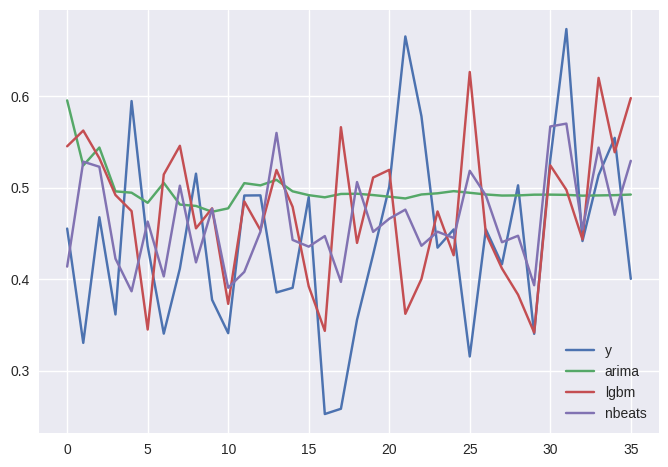

In [85]:
results_df = {'y'      : test.all_values().flatten(),
              'arima'  : arima_predict.all_values().flatten(),
              'lgbm'   : lgbm_predict.all_values().flatten(),
              'nbeats' : nbeats_predict.all_values().flatten()}
results_df = pd.DataFrame(results_df)
results_df.plot()